# Visualizing compoments 
That is, each feature loading (weights) on each PC. They can be positive or negative (inticating direction). 
- Bold lines represent the average (mean) loading of that PC over all features at each time.

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from typing import List
import os
import glob


In [19]:
base_dir = 'results/'
folder = 'components'
folder_path = os.path.join(base_dir, folder)
csv_files = glob.glob(os.path.join(folder_path, 'event_StagEventNew/components_event_StagEventNew_timestamp_all_5_variables.csv'))
print(f"Found {len(csv_files)} CSV files in /data/pca_results/components/:")
for f in csv_files:
    print(f"File: {os.path.basename(f)}")

if not csv_files:
    raise FileNotFoundError("No CSV files found in /data/pca_results/components/")

# Only allow a single file to be loaded; if multiple, warn and ask user to specify which
if len(csv_files) == 0:
    raise FileNotFoundError("No CSV files found in /data/pca_results/components/")
elif len(csv_files) == 1:
    components_df = pd.read_csv(csv_files[0])
else:
    print("Warning: Multiple CSV files found in /data/pca_results/components/:")
    for idx, f in enumerate(csv_files):
        print(f"{idx}: {os.path.basename(f)}")
    raise RuntimeError("Multiple component files found. Please specify which file to load by setting the correct path or removing extra files.")
components_df

Found 1 CSV files in /data/pca_results/components/:
File: components_event_StagEventNew_timestamp_all_5_variables.csv


,PC1,PC2,PC3,PC4,PC5,Features,Time,Event
0,-0.631352,0.363047,-0.330614,-0.600239,0.000000,Eye Horizontal,-5.0,NoEvent
1,0.596169,-0.313511,-0.507959,-0.536908,0.000000,Eye Vertical,-5.0,NoEvent
2,-0.409846,-0.548688,-0.591773,0.425173,0.000000,Head Horizontal,-5.0,NoEvent
3,0.279292,0.684725,-0.531485,0.413123,0.000000,Head Vertical,-5.0,NoEvent
4,0.000000,0.000000,-0.000000,-0.000000,1.000000,Steering,-5.0,NoEvent
...,...,...,...,...,...,...,...,...
2500,-0.331133,0.592374,-0.394176,-0.288337,0.548571,Eye Horizontal,5.0,NoEvent
2501,-0.501960,-0.415283,0.138891,-0.732621,-0.139830,Eye Vertical,5.0,NoEvent
2502,-0.593383,0.213761,-0.303116,0.347096,-0.624378,Head Horizontal,5.0,NoEvent
2503,-0.415006,-0.557740,-0.111116,0.479434,0.523921,Head Vertical,5.0,NoEvent


In [20]:
features = components_df['Features'].unique()
components_df = components_df.drop(columns=['Features']).melt(id_vars=['Time','Event'], var_name='PCs', value_name='pca_value')
components_df

,Time,Event,PCs,pca_value
0,-5.0,NoEvent,PC1,-0.631352
1,-5.0,NoEvent,PC1,0.596169
2,-5.0,NoEvent,PC1,-0.409846
3,-5.0,NoEvent,PC1,0.279292
4,-5.0,NoEvent,PC1,0.000000
...,...,...,...,...
12520,5.0,NoEvent,PC5,0.548571
12521,5.0,NoEvent,PC5,-0.139830
12522,5.0,NoEvent,PC5,-0.624378
12523,5.0,NoEvent,PC5,0.523921


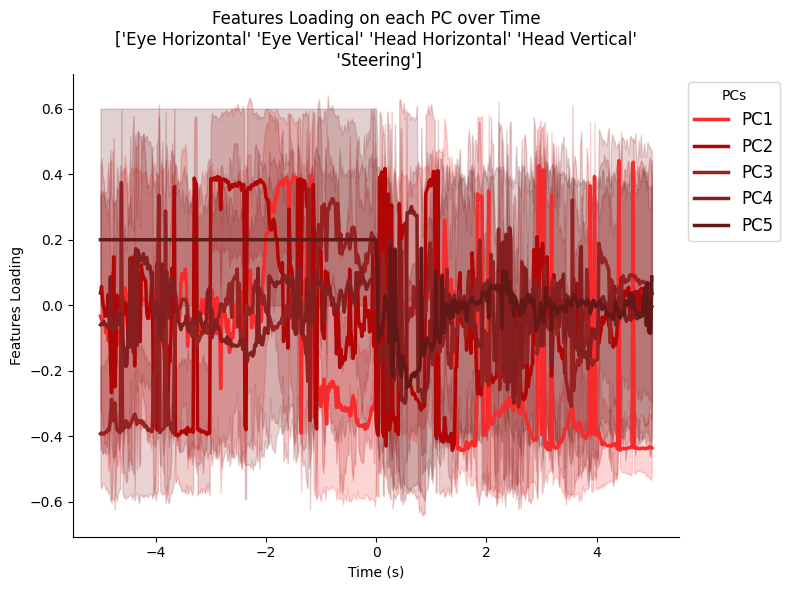

In [21]:
import matplotlib.pyplot as plt

# Example color palette you provided
color_pca = {
    'PC1': '#F72B2B', 'PC2': '#B10606',
    'PC3': '#962222', 'PC4': '#851E1E',
    'PC5': '#641717', 'PC6': '#430F0F',
    # 'PC7': '#3A0E0E', 'PC8': '#320C0C',
    # 'PC9': '#2B0A0A', 'PC10': '#240808'
}

# Select PCs to plot
pcs = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']

fig, ax= plt.subplots(figsize=(8, 6))

sns.lineplot(x='Time', y='pca_value', data=components_df, hue='PCs', linewidth=2.5, linestyle='-', palette=color_pca)
# for pc in pcs:
#     ax.plot(variances_df['Time'], variances_df[pc], label=pc, color=color_pca.get(pc, '#000000'))
# Remove the default legend as we'll create a custom one later
# ax.legend()#.remove()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), fontsize=12)
sns.despine(ax=ax, offset=0, trim=False)
plt.xlabel('Time (s)')
plt.ylabel('Features Loading')
plt.title(f'Features Loading on each PC over Time\n{features}')
# plt.legend(title='Principal Components')
plt.grid(False)
plt.tight_layout()
plt.show()

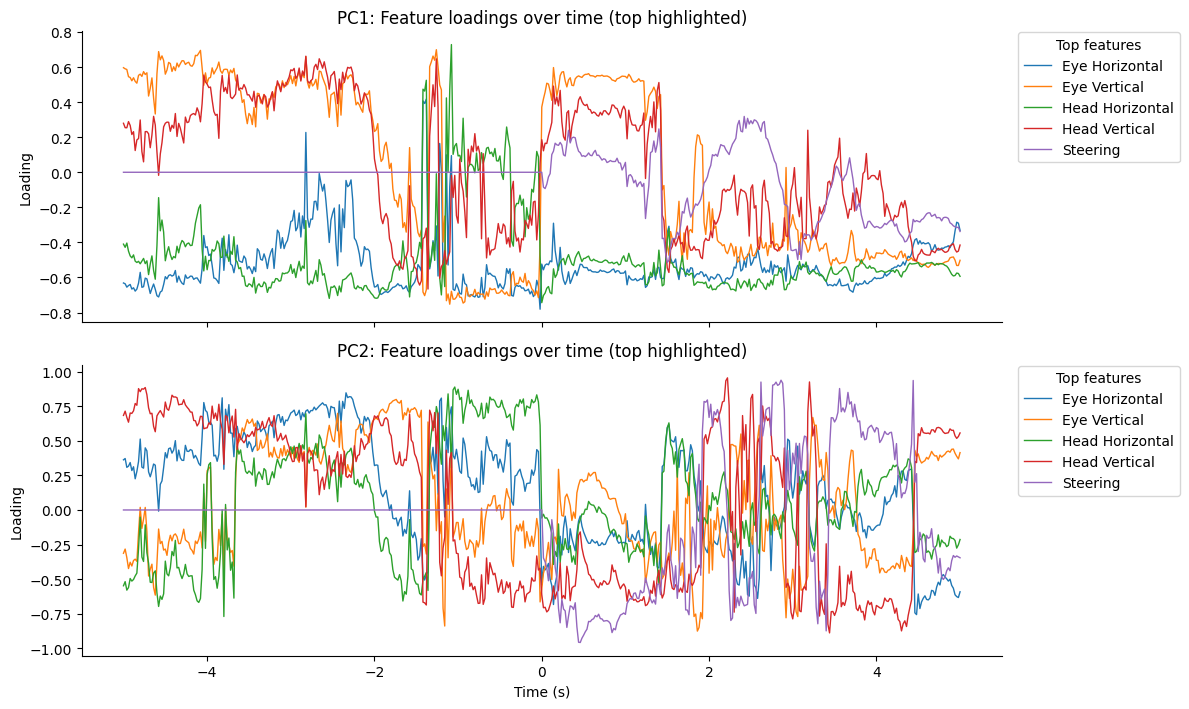

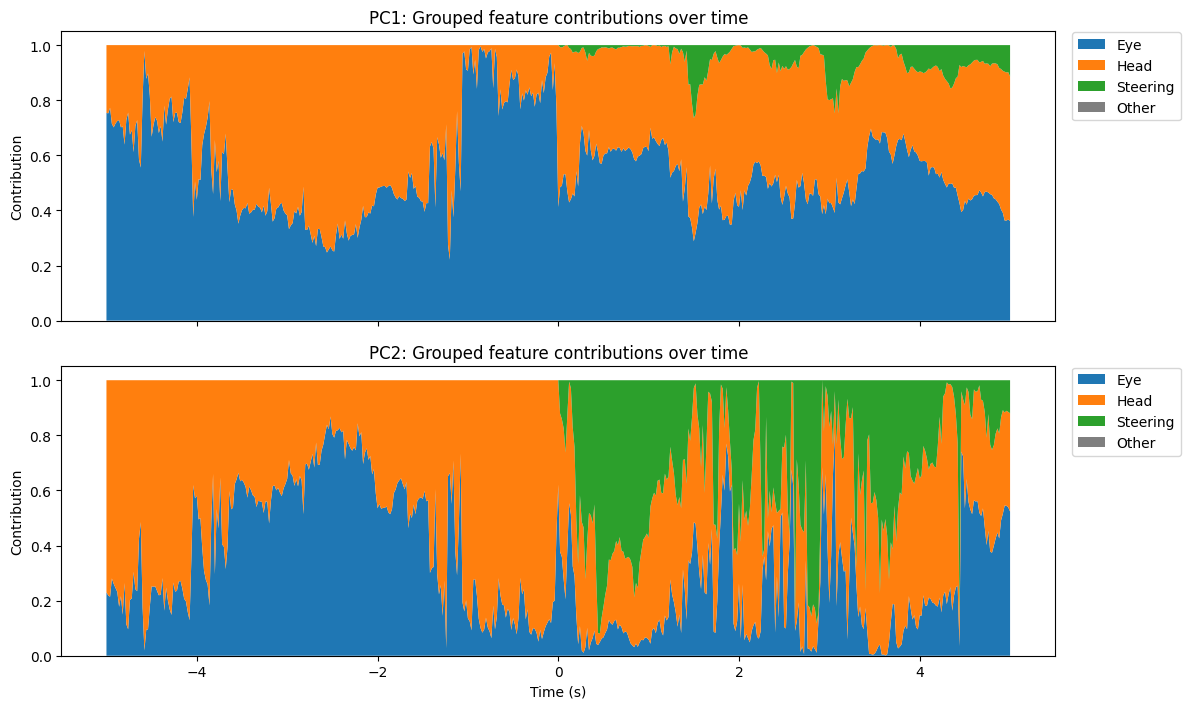

In [30]:
# =========================
# Feature-aware PCA visuals
# =========================
# This cell builds a tidy long table that retains `Features` and adds
# per-feature contributions, then renders several complementary views:
#   1) Heatmaps of signed loadings (Features x Time) per PC
#   2) Heatmaps of percent contributions (non-negative) per PC
#   3) Top-K stacked area contributions for a chosen PC
#   4) Small-multiples line plots with top features highlighted
#   5) Grouped contributions over time (Eye / Head / Steering / Other)


def _find_pc_columns(df: pd.DataFrame) -> List[str]:
    return [c for c in df.columns if isinstance(c, str) and c.startswith('PC')]


def _load_components_wide_from_memory_or_disk() -> pd.DataFrame:
    """Return wide components with columns ['Time','Event'|'EventName','Features','PC1', ...].
    Prefers in-memory variables; falls back to the most recent CSV under results/components/."""
    # Prefer in-memory objects if any contain Features + PC columns
    for var_name in ['components_df', 'components_wide', 'components_full', 'components_features', 'components_raw']:
        if var_name in globals():
            obj = globals()[var_name]
            if isinstance(obj, pd.DataFrame):
                if 'Features' in obj.columns and len(_find_pc_columns(obj)) > 0:
                    return obj.copy()
    # Otherwise search results/components recursively
    base = Path('results/components')
    candidates = sorted(base.rglob('components_*.csv'), key=lambda p: p.stat().st_mtime, reverse=True)
    if not candidates:
        raise FileNotFoundError("No components CSV with 'Features' and PC columns found under results/components/.")
    df = pd.read_csv(candidates[0])
    return df


def _align_pc_signs_over_time(wide_df: pd.DataFrame, pc_cols: List[str], time_col: str = 'Time', feature_col: str = 'Features') -> pd.DataFrame:
    """Align signs to avoid arbitrary flips across time using consecutive dot products per PC."""
    if time_col not in wide_df.columns:
        return wide_df.copy()
    aligned_blocks = []
    previous_vectors: dict[str, np.ndarray | None] = {pc: None for pc in pc_cols}
    # Deterministic ordering so dot products are meaningful
    for t, block in wide_df.groupby(time_col, sort=True):
        block_sorted = block.sort_values(feature_col).copy()
        for pc in pc_cols:
            v = block_sorted[pc].to_numpy()
            prev = previous_vectors[pc]
            if prev is not None and np.dot(prev, v) < 0:
                block_sorted[pc] = -block_sorted[pc]
                v = -v
            previous_vectors[pc] = v
        aligned_blocks.append(block_sorted)
    return pd.concat(aligned_blocks, ignore_index=True)


def _feature_group_from_name(name: str) -> str:
    s = str(name).lower()
    if 'eye' in s:
        return 'Eye'
    if 'nose' in s or 'head' in s:
        return 'Head'
    if 'steer' in s:
        return 'Steering'
    return 'Other'


def _get_variance_long_if_available() -> pd.DataFrame | None:
    """Return long variance ratios with columns ['Time','PC','explained_variance_ratio'] if available."""
    if 'variances_df' not in globals():
        return None
    vdf = globals()['variances_df']
    if not isinstance(vdf, pd.DataFrame):
        return None
    cols = set(vdf.columns)
    # Already long
    if {'Time', 'PCs', 'pca_value'}.issubset(cols):
        out = vdf.rename(columns={'PCs': 'PC', 'pca_value': 'explained_variance_ratio'})
        return out[['Time', 'PC', 'explained_variance_ratio']].copy()
    # Wide -> melt
    pc_cols = _find_pc_columns(vdf)
    if {'Time'}.issubset(cols) and len(pc_cols) > 0:
        out = vdf.melt(id_vars=['Time'], value_vars=pc_cols, var_name='PC', value_name='explained_variance_ratio')
        return out
    return None


# 1) Acquire wide components with Features and PCs
_components_wide = _load_components_wide_from_memory_or_disk()
pc_cols = _find_pc_columns(_components_wide)
# Normalize event column name
if 'Event' not in _components_wide.columns and 'EventName' in _components_wide.columns:
    _components_wide = _components_wide.rename(columns={'EventName': 'Event'})

# 2) Align signs for stability across time
_components_wide = _align_pc_signs_over_time(_components_wide, pc_cols)

# 3) Long format with loadings and derived contributions
components_long_vis = _components_wide.melt(
    id_vars=['Time', 'Event', 'Features'], value_vars=pc_cols,
    var_name='PC', value_name='loading'
)
components_long_vis['abs_loading'] = components_long_vis['loading'].abs()
components_long_vis['contribution'] = components_long_vis['loading'] ** 2
components_long_vis['group'] = components_long_vis['Features'].apply(_feature_group_from_name)

# Normalize to percent contribution within each Time x Event x PC
sum_contrib = components_long_vis.groupby(['Time', 'Event', 'PC'])['contribution'].transform('sum')
components_long_vis['pct_contribution'] = np.where(sum_contrib > 0, components_long_vis['contribution'] / sum_contrib, 0.0)

# Optionally weight by explained variance ratio if available
var_long = _get_variance_long_if_available()
# Ensure comparable numeric dtype for 'Time' prior to merging
components_long_vis['Time'] = pd.to_numeric(components_long_vis['Time'], errors='coerce')
if var_long is not None:
    var_long = var_long.copy()
    var_long['Time'] = pd.to_numeric(var_long['Time'], errors='coerce')
    components_long_vis = components_long_vis.merge(var_long, on=['Time', 'PC'], how='left')
    components_long_vis['weighted_contribution'] = components_long_vis['pct_contribution'] * components_long_vis['explained_variance_ratio']
else:
    components_long_vis['explained_variance_ratio'] = np.nan
    components_long_vis['weighted_contribution'] = np.nan

# PCs to visualize: respect existing `pcs` if defined
pcs_to_plot = [pc for pc in globals().get('pcs', pc_cols) if pc in pc_cols]
if not pcs_to_plot:
    pcs_to_plot = pc_cols[:4]

# number of PCs to plot
num_pcs = 2#len(pcs_to_plot)

# # -----------------------------
# # 1) Heatmaps: signed loadings
# # -----------------------------
# fig, axes = plt.subplots(num_pcs, 1, figsize=(12, 3.6 * num_pcs), sharex=True)
# if num_pcs == 1:
#     axes = [axes]
# for ax, pc in zip(axes, pcs_to_plot):
#     df_pc = components_long_vis[components_long_vis['PC'] == pc].copy()
#     feat_order = df_pc.groupby('Features')['abs_loading'].mean().sort_values(ascending=False).index
#     piv = df_pc.pivot_table(index='Features', columns='Time', values='loading', aggfunc='mean')
#     piv = piv.reindex(index=feat_order)
#     vmax = float(np.nanpercentile(np.abs(df_pc['loading']), 95)) if df_pc['loading'].notna().any() else 1.0
#     sns.heatmap(piv, cmap='coolwarm', center=0, vmin=-vmax, vmax=vmax, ax=ax, cbar_kws={'label': 'Loading'})
#     ax.set_title(f'{pc}: Signed loadings over time')
#     ax.set_ylabel('Features')
# axes[-1].set_xlabel('Time (s)')
# plt.tight_layout()
# plt.show()

# # -----------------------------------------
# # 2) Heatmaps: percent contribution (>= 0)
# # -----------------------------------------
# fig, axes = plt.subplots(num_pcs, 1, figsize=(12, 3.6 * num_pcs), sharex=True)
# if num_pcs == 1:
#     axes = [axes]
# for ax, pc in zip(axes, pcs_to_plot):
#     df_pc = components_long_vis[components_long_vis['PC'] == pc]
#     feat_order = df_pc.groupby('Features')['pct_contribution'].mean().sort_values(ascending=False).index
#     piv = df_pc.pivot_table(index='Features', columns='Time', values='pct_contribution', aggfunc='mean')
#     piv = piv.reindex(index=feat_order)
#     vmax = float(np.nanpercentile(df_pc['pct_contribution'], 99)) if df_pc['pct_contribution'].notna().any() else 1.0
#     sns.heatmap(piv, cmap='magma', vmin=0, vmax=max(0.01, vmax), ax=ax, cbar_kws={'label': 'Percent contribution'})
#     ax.set_title(f'{pc}: Feature contributions (sum=1 per time)')
#     ax.set_ylabel('Features')
# axes[-1].set_xlabel('Time (s)')
# plt.tight_layout()
# plt.show()

# -------------------------------------------------
# 3) Stacked area: Top-K contributions for one PC
# -------------------------------------------------
# pc_focus = pcs_to_plot[0]
# top_k = 5
# pc_df = components_long_vis[components_long_vis['PC'] == pc_focus]
# feat_rank = pc_df.groupby('Features')['pct_contribution'].mean().sort_values(ascending=False)
# top_feats = list(feat_rank.head(top_k).index)
# area_df = (
#     pc_df[pc_df['Features'].isin(top_feats)]
#     .pivot_table(index='Time', columns='Features', values='pct_contribution', aggfunc='mean')
#     .sort_index()
#     .fillna(0.0)
# )
# # Add Others category to complete the stack to 1
# others = (1.0 - area_df.sum(axis=1)).clip(lower=0.0)
# area_df['Other'] = others
# colors = sns.color_palette('tab20', n_colors=len(area_df.columns))
# plt.figure(figsize=(12, 4.6))
# plt.stackplot(area_df.index.values, area_df.T.values, labels=list(area_df.columns), colors=colors)
# plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1.02))
# plt.title(f'{pc_focus}: Top-{top_k} feature contributions over time (stacked)')
# plt.xlabel('Time (s)')
# plt.ylabel('Contribution')
# plt.tight_layout()
# plt.show()

# ------------------------------------------------------
# 4) Small multiples: feature loadings, top highlighted
# ------------------------------------------------------
fig, axes = plt.subplots(num_pcs, 1, figsize=(12, 3.6 * num_pcs), sharex=True)
if num_pcs == 1:
    axes = [axes]
for ax, pc in zip(axes, pcs_to_plot):
    df_pc = components_long_vis[components_long_vis['PC'] == pc]
    top_feats = (
        df_pc.groupby('Features')['abs_loading'].mean().sort_values(ascending=False).head(5).index.tolist()
    )
    for feat, sub in df_pc.groupby('Features'):
        sub_sorted = sub.sort_values('Time')
        alpha = 1.0 if feat in top_feats else 0.25
        lw = 1.0 if feat in top_feats else 1.0
        ax.plot(sub_sorted['Time'], sub_sorted['loading'], label=feat if feat in top_feats else None,
                alpha=alpha, linewidth=lw)
    if top_feats:
        ax.legend(title='Top features', loc='upper left', bbox_to_anchor=(1.01, 1.02))
    ax.set_title(f'{pc}: Feature loadings over time (top highlighted)')
    ax.set_ylabel('Loading')
    sns.despine(ax=ax, offset=0, trim=False)
axes[-1].set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

# ----------------------------------------------------
# 5) Grouped contributions: Eye / Head / Steering
# ----------------------------------------------------
_group_colors = {
    'Eye': '#1f77b4',
    'Head': '#ff7f0e',
    'Steering': '#2ca02c',
    'Other': '#7f7f7f',
}
fig, axes = plt.subplots(num_pcs, 1, figsize=(12, 3.6 * num_pcs), sharex=True)
if num_pcs == 1:
    axes = [axes]
for ax, pc in zip(axes, pcs_to_plot):
    agg = (
        components_long_vis[components_long_vis['PC'] == pc]
        .groupby(['Time', 'group'])['pct_contribution']
        .sum()
        .reset_index()
    )
    pivot = agg.pivot(index='Time', columns='group', values='pct_contribution').sort_index().fillna(0.0)
    for g in ['Eye', 'Head', 'Steering', 'Other']:
        if g not in pivot.columns:
            pivot[g] = 0.0
    pivot = pivot[['Eye', 'Head', 'Steering', 'Other']]
    ax.stackplot(pivot.index.values, pivot.T.values, labels=list(pivot.columns),
                 colors=[_group_colors[g] for g in pivot.columns])
    ax.set_title(f'{pc}: Grouped feature contributions over time')
    ax.set_ylabel('Contribution')
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1.02))
axes[-1].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

